# Lab2. Amazon SageMaker Random Cut Forest

As a next step after preparing data, we wil build Random cut forrest model using Amazon SageMaker. Amazon SageMaker is a fully managed machine learning service. Amazon SageMaker provides several built-in machine learning algorithms that you can use for a variety of problem types. There are dozens of built-in algorithms like [Linear learner algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html), the [XGBoost Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) as well as [Random Cut Forest](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html) (RCF). We use the RCF that is an unsupervised algorithm to detect anomalous data points within a data set. 

## Table Of Contents
The overall process for this is:
1. Setup
1. Data Preparation (3 feature timeseries by minute)
1. Training the RCF Model  
1. Detecting spikes with the Model  
1. Plotting results  
1. Stop and Delete the Endpoint
1. (Optional) Additional experiements
 
To get started, simply execute the cells below:

## 1. Setup 

Please make sure you already finished 1st step - [1.Exploratory_Data_Analysis.ipynb](1.Exploratory_Data_Analysis.ipynb)

In [2]:
%store -r

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import boto3
import botocore
import sagemaker
import sys
from sagemaker import RandomCutForest

In [9]:
session = sagemaker.Session()
bucket = session.default_bucket()
execution_role = sagemaker.get_execution_role()

## 2. Data Preparation (3 feature timeseries by minute)

For preparing a training dataset, We use aggagated timeseries with 3 features of the number of **visited urls, the number of visitors, and the numbor of clicks in 1 minute.**

In [4]:
clickstream_1T.head()

,urls,users,clicks
timestamp,,,
2012-03-01 00:00:00,3,4,5
2012-03-01 00:01:00,2,3,4
2012-03-01 00:02:00,1,4,4
2012-03-01 00:03:00,4,4,5
2012-03-01 00:04:00,5,6,9


Let's see the trends and patterns of clicks graphically by plotting the dataset. Several spikes can be observed (e.g. near 6th and 13th March)

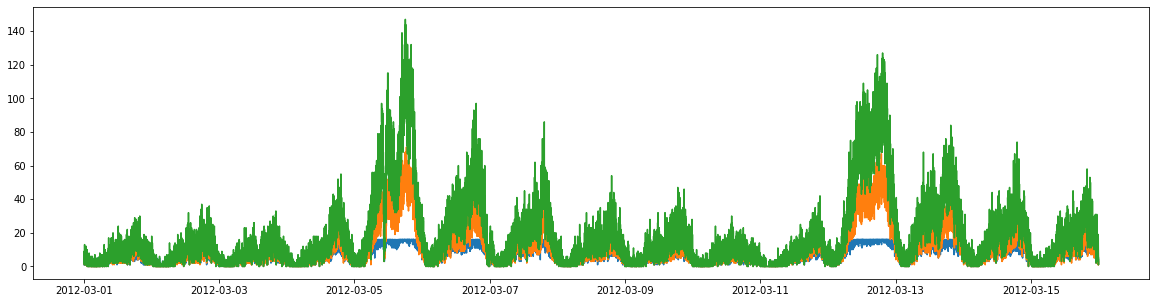

In [5]:
plt.figure(figsize=(20,5))
plt.plot(clickstream_1T)
plt.show()

We will use below s3 path with default bucket

In [13]:
prefix = 'rcf-clickstream'
print("s3://{}/{}".format(bucket,prefix))

s3://sagemaker-us-east-1-308961792850/rcf-clickstream


## 3. Creating the RCF Model

We train the model with SageMaker built-in RandomCutForest algorithm. The algorithm takes a bunch of random data points (Random), cuts them to the same number of points and creates trees (Cut). It then looks at all of the trees together (Forest) to determine whether a particular data point is an anomaly. 

A tree is an ordered way of storing numerical data. The simplest type of tree is called a binary tree. It’s a great way to store data because it’s easy and fast for a computer to use. To create a tree, you randomly subdivide the data points until you isolate the point you’re testing to determine whether it’s an anomaly. Each time you subdivide the data points, it creates a new level of the tree.  

The fewer times you need to subdivide the data points before you isolate the target data point the more likely it is that the data point is an anomaly for that sample of data.

You can find more deteiled information from [here](https://docs.aws.amazon.com/sagemaker/latest/dg/rcf_how-it-works.html).

### Training job

Define RandomCutorest and set the hyperparameters for RCF training:

* **num_samples_per_tree** - the number randomly sampled data points sent to each tree. As a general rule, **1/num_samples_per_tree** should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **num_trees** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **feature_dim** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: ml.m4, ml.c4, or ml.c5
* Current limitations:
    * The RCF algorithm does not take advantage of GPU hardware.

In [15]:
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=256,
                      num_trees=100)

There is an utility record_set() that can be used to upload data to S3 and creates RecordSet to be passed to the fit call.

In [17]:
# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(clickstream_1T.to_numpy()))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-30 03:47:41 Starting - Starting the training job...
2020-09-30 03:47:48 Starting - Launching requested ML instances......
2020-09-30 03:48:52 Starting - Preparing the instances for training...
2020-09-30 03:49:39 Downloading - Downloading input data...
2020-09-30 03:49:56 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[09/30/2020 03:50:53 INFO 139980429375296] Reading default configuration from /opt/amazon/lib/python2.7/site-packa

## 4. Detecting spikes with the Model  

After you train your model, you can deploy it to get predictions. We can detect unexpected spikes on the website by fetching anomaly socres from this endpoint.

In [19]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

Next code will set the serializer and deserializer of the endpoint. We make use of the SageMaker Python SDK utilities csv_serializer and json_deserializer when configuring it.

We can pass data in a variety of formats to the endpoint. In this example we will use CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. 

In [20]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

Call the predict() method and check the first 10 data points to see what the output looks like.

In [22]:
results = rcf_inference.predict(clickstream_1T.to_numpy())
results['scores'][:10]

[{'score': 1.5023823129},
 {'score': 1.6655507459},
 {'score': 1.8805858469},
 {'score': 1.3583180304},
 {'score': 1.319181352},
 {'score': 1.319181352},
 {'score': 1.9232194815},
 {'score': 1.5781412544},
 {'score': 1.3530663326},
 {'score': 1.3560324344}]

Next, let's look at the distribution of inference results(anomaly scores). We need to decide a thresold to determin whether it is abnomarl or not. Plotting a histogram is often useful when deciding the threshold of anomaly scores. 

Since RCF is an unsupervised algorithm, label data is not required. However, if you have even some of labeled data to distingish whether they are normal or not, you can use them to decide the thresold by **choosing the number to prduce the highest precision, recall, or F1 score**. This also means this labeled data can be used for perfomance metrics for our model. If you pass the test dataset into the training job as a test channel, SageMaker will return this score. (Test data channel is optional)

If you do not have labeled data, you can choose **3 standard deviations** (approximately 99.9th percentile) as a rule of thumb (assuming the score is normaly distributed). Or, you can use an appropriate value by visually checking changes of the graph or the distribution of the histogram. 

From our result, 3 standard deviations value is around 5.36

In [56]:
results_pd = pd.DataFrame(results['scores'])
threshold = results_pd.mean() + results_pd.std()*3
threshold.values[0]

5.356431568494441

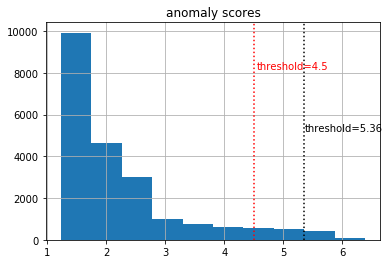

In [58]:
results_pd.hist()
plt.title('anomaly scores')
plt.axvline(x=4.5, linestyle=':', color='r')
plt.annotate('threshold=4.5', xy=(4.55,8200), color='r')
plt.axvline(x=threshold.values, linestyle=':', color='k')
plt.annotate('threshold={}'.format(round(threshold.values[0],2)), xy=(threshold,5200))
plt.show()

Threshold will depend on the application.  
In this example, we chose a value around 4.5 just for easier result explanation.  

In [40]:
threshold = 4.5

## 5. Plotting the Prediction

The code below will plot time sereis with anomalies. The algorithm detected anomalies accroding to the changes and deviations in each feature value instead of using a fixed threshold.

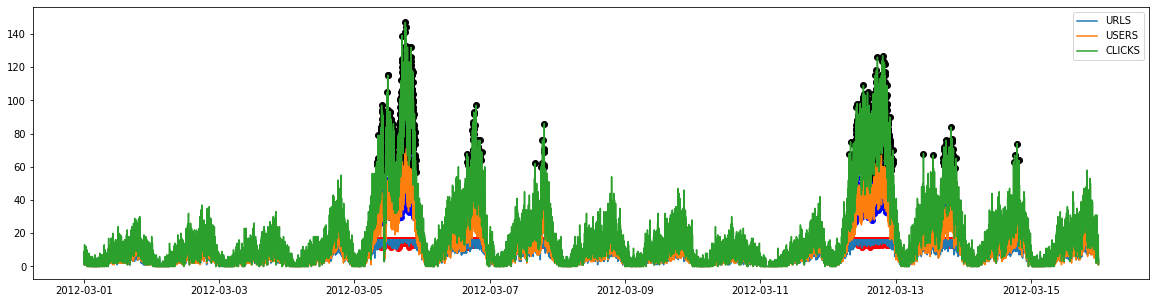

In [42]:
plt.figure(figsize=(20,5))
plt.plot(clickstream_1T)
anomalous = clickstream_1T[list((results_pd > threshold)['score'])]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.legend(legend)
plt.show()

The graph above may seem too complicated. Let's zoom in the time around March 06 to look at the results in detail.

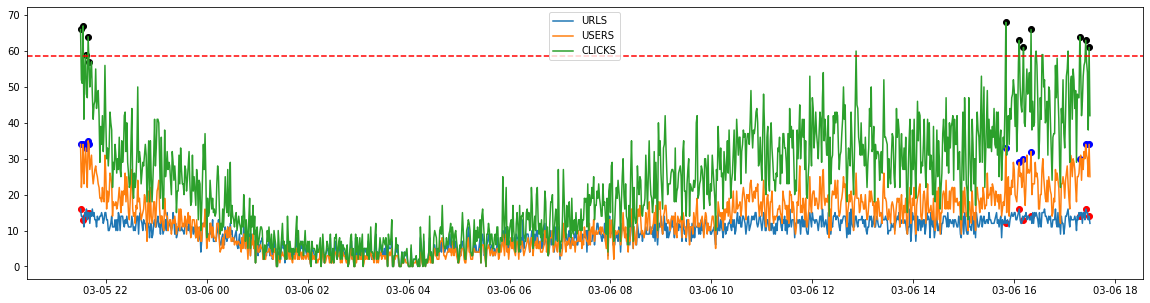

In [46]:
plt.figure(figsize=(20,5))
z_from = "2012-03-05 21:30:00"
z_to = "2012-03-06 17:30:00"
plt.plot(clickstream_1T[z_from:z_to])
anomalous = clickstream_1T[list((results_pd > threshold)['score'])][z_from:z_to]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.axhline(y=58.5, linestyle='--', c='r')
plt.legend(legend)
plt.show()

It can be seen that anomaly scores are not calculated solely based on deviations from a fixed upper or lower limit. Some points marked as anomaly are placed below the dotted red line and some points marked normal are placed above the red line. (Dotted line is a subsidiary for visual comparison.)

Remember we used 3 features (URLS, USERS, and CLICKS) and the algorithm would have taken these values into account to pull the result. If you use this anomaly score as a threshold instead of a simple fixed upper/lower limit, this will allow you to find anomalous points more dynamically.

To examine the relationship between anomaly scores and feature deviations, we plot the residuals of clicks and users. The graph below illustrates this change. We can understand that anomalous sources were returned, not only by residual or just the amount of value.

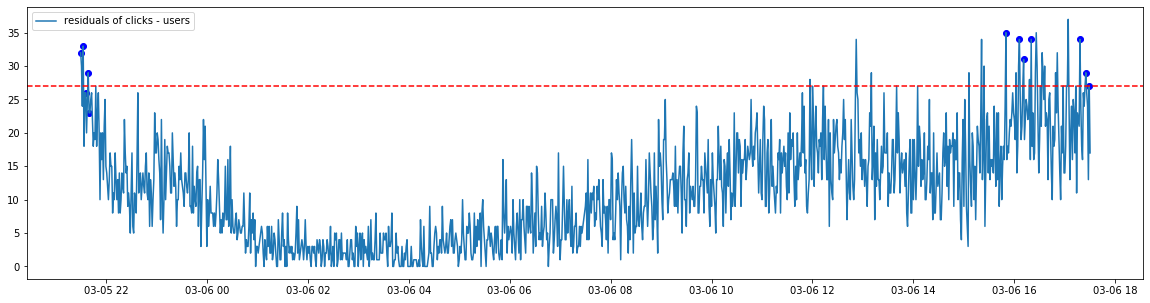

In [51]:
plt.figure(figsize=(20,5))
plt.plot(clickstream_1T['clicks']-clickstream_1T['users'][z_from:z_to])
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values - anomalous['users'].values, c='blue')
plt.legend(['residuals of clicks - users'])
plt.axhline(y=27, linestyle='--', c='r')
plt.show()

## 6. Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do this, execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [49]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

Next, move to [LAB3](3.Amazon_SageMaker_DeepAR.ipynb) to see how to make use of time series prediction to detect anomalies

<br>

---
## 7. (Optional) Additional experiments

The code below shows additional experiments 1) how to apply different time sampling and 2) Shingling. If you want to know a little more about how to use RCF, let's try it.

### 1) Experiments with different frequency

In the same way, you can see the result of other time sampling.  
Below is the same code that we ran in previous steps but only the time sampling rate of dataset is changed to 1 hour. 

In [72]:
# specify general training job information
prefix = 'rcf-clickstream-1h'
rcf_1h = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=256,
                      num_trees=100)
rcf_1h.fit(rcf_1h.record_set(clickstream_1H.to_numpy()))

rcf_inf_1h = rcf_1h.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)
rcf_inf_1h.content_type = 'text/csv'
rcf_inf_1h.serializer = csv_serializer
rcf_inf_1h.accept = 'application/json'
rcf_inf_1h.deserializer = json_deserializer
results_1h = rcf_inf_1h.predict(clickstream_1H.to_numpy())


The range of AD Score values is different. 3 std value is 1.54 but it seens too high. 
This time we will choose 1.43 as the threshold.

In [69]:
results_1h_pd = pd.DataFrame(results_1h['scores'])
threshold_1h = results_1h_pd.mean() + results_1h_pd.std()*3
threshold_1h.values[0]

1.5441255714449615

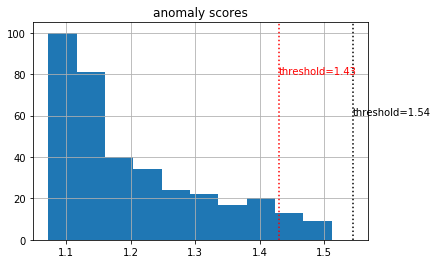

In [71]:
results_1h_pd.hist()
plt.title('anomaly scores')
plt.axvline(x=1.43, linestyle=':', color='r')
plt.annotate('threshold=1.43', xy=(1.43,80), color='r')
plt.axvline(x=threshold_1h.values, linestyle=':', color='k')
plt.annotate('threshold={}'.format(round(threshold_1h.values[0],2)), xy=(threshold_1h,60))
plt.show()

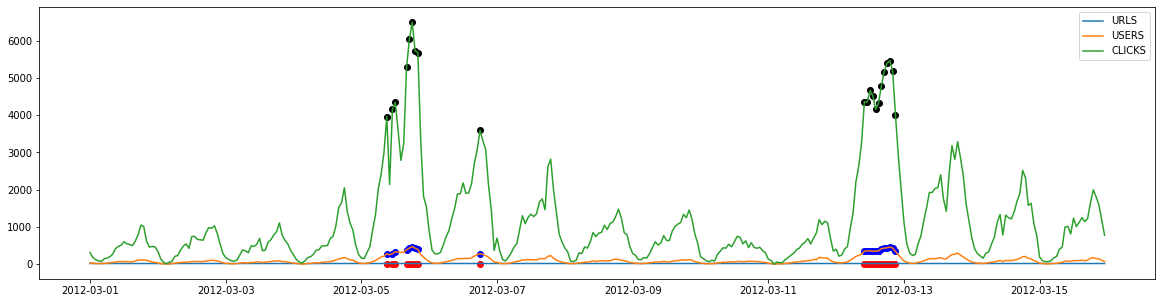

In [114]:
threshold_1h = 1.43
plt.figure(figsize=(20,5))
plt.plot(clickstream_1H)
anomalous_1h = clickstream_1H[list((results_1h_pd > threshold_1h)['score'])]
plt.scatter(x= anomalous_1h.index, y=anomalous_1h['urls'].values, c='red')
plt.scatter(x= anomalous_1h.index, y=anomalous_1h['users'].values, c='blue')
plt.scatter(x= anomalous_1h.index, y=anomalous_1h['clicks'].values, c='black')
plt.legend(legend)
plt.show()

### 2) Experiments with Shingling

Shingling is the one of the preprocessing techniques in timeseris. It add value changes over time as a feature in a time window.  


```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],  
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],  
        ...                                ...  
        [x_N]]                             [x_{N-P}, ..., x_{N}]]  
```

The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

This is especially useful when working with periodic data with known period. In our dataset, we can see clicks per hour changes every 24 hours. We will add 24 hours Shingling to the hourly dataset and do the detection again.


In [81]:
def shingle(data, shingle_size=24):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data


In [108]:
shingle_ds = []
for c in ['urls','users','clicks']:
    shingle_data = shingle(clickstream_1H[c])
    shingle_ds.append(shingle_data)
shingle_ds = np.concatenate(shingle_ds,axis=1)
shingle_ds

array([[  16.,   16.,   16., ...,  459.,  473.,  463.],
       [  16.,   16.,   16., ...,  473.,  463.,  344.],
       [  16.,   16.,   14., ...,  463.,  344.,  143.],
       ...,
       [  16.,   16.,   16., ..., 1652., 1996., 1806.],
       [  16.,   16.,   16., ..., 1996., 1806., 1589.],
       [  16.,   16.,   16., ..., 1806., 1589., 1186.]])

In [109]:
prefix = 'rcf-clickstream-shingle'
rcf_sg = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=256,
                      num_trees=100)
rcf_sg.fit(rcf_sg.record_set(shingle_ds))

rcf_inf_sg = rcf_sg.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)
rcf_inf_sg.content_type = 'text/csv'
rcf_inf_sg.serializer = csv_serializer
rcf_inf_sg.accept = 'application/json'
rcf_inf_sg.deserializer = json_deserializer
results_sg = rcf_inf_sg.predict(shingle_ds)

In [104]:
results_sg_pd = pd.DataFrame(results_1h['scores'])
threshold_sg = results_sg_pd.mean() + results_sg_pd.std()*3
threshold_sg.values[0]

1.5441255714449615

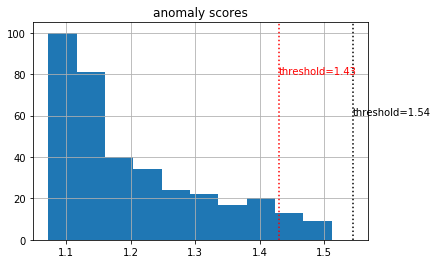

In [106]:
results_sg_pd.hist()
plt.title('anomaly scores')
plt.axvline(x=1.43, linestyle=':', color='r')
plt.annotate('threshold=1.43', xy=(1.43,80), color='r')
plt.axvline(x=threshold_1h.values, linestyle=':', color='k')
plt.annotate('threshold={}'.format(round(threshold_1h.values[0],2)), xy=(threshold_1h,60))
plt.show()

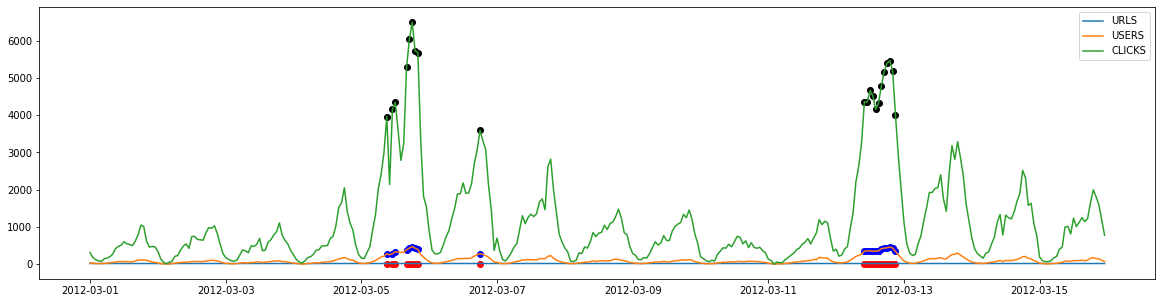

In [123]:
threshold_sg = 1.43
plt.figure(figsize=(20,5))
plt.plot(clickstream_1H)
anomalous_sg = clickstream_1H[list((results_sg_pd > threshold_sg)['score'])]
plt.scatter(x= anomalous_sg.index, y=anomalous_sg['urls'].values, c='red')
plt.scatter(x= anomalous_sg.index, y=anomalous_sg['users'].values, c='blue')
plt.scatter(x= anomalous_sg.index, y=anomalous_sg['clicks'].values, c='black')
plt.legend(legend)
plt.show()

Although the result of the test is not that much different from the previous experiment, Shingling is one of the important experiment that we should try.  
We will look at Shingling in the 4th Kinesis Lab again.

### Delete endpoint

Delete the endpoint again before you close the notebook.

In [110]:
# sagemaker.Session().delete_endpoint(rcf_inference.endpoint)
sagemaker.Session().delete_endpoint(rcf_inf_1h.endpoint)